# Batch Catalog Extractions

This notebook demonstrates how to query the survey for datacubes based on a list of coordinates. It can either be run on compressed (archival) datacubes or decompressed data as decompressed in 09-BatchDecompression.ipynb

In [2]:
import os.path as op
import numpy as np
from astropy.table import Column, Table, hstack, unique

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.io.fits.hdu.compressed import CompImageHDU

from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import time

In [3]:
# this is archival datacube location
pdr_dir = '/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/'
#optimally use decompressed files for faster extractions
decompressed_dir ='/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/'

if not op.exists(pdr_dir):
    pdr_dir = '/home/jovyan/work/pdr1/'
    decompressed_dir = pdr_dir    

ifu_data = Table.read(op.join( pdr_dir, 'ifu-index.fits'))

In [4]:
# Create SkyCoord Object array for IFU centers
ifu_coords = SkyCoord( ra=ifu_data['ra_cen']*u.deg, dec=ifu_data['dec_cen']*u.deg)

In [5]:
catalog = unique( Table.read('dr16q_hdr5.fits'), keys='sdss_name')

catalog.remove_column('shotid') # this example might be done witih different catalog later
catalog_coords = SkyCoord(ra = catalog['ra'], dec= catalog['dec'], unit='deg')

In [6]:
idx_ifu, idx_catalog, d2d, d3d = catalog_coords.search_around_sky(ifu_coords, 35*u.arcsec)

In [7]:
# create master table that matches IFU observation coverage with catalog objects

In [8]:
table = hstack( [catalog_coords[idx_catalog], catalog[idx_catalog], ifu_data[idx_ifu]] )
table.rename_column('col0', 'coords')

In [9]:
table['shotid', 'ifuslot'].write('pdr1_decompressed.fits')

In [10]:
# reduce table to unique rows

## Define function get_spectra to efficiently extract 1D spectra from a datacube. 

In [11]:
def get_spectra(
    coord,
    shotid,
    ifuslot,
    data_dir=pdr_dir,
    radius=3.5,
    padding_pix=2
):
    """
    Extract a 1D spectrum and error from a HETDEX IFU cube using a circular aperture, reading only a local subcube.

    Parameters
    ----------
    coord : astropy.coordinates.SkyCoord
        Sky coordinate in ICRS (RA, Dec).
    shotid : int
        Shot ID of the observation.
    ifuslot : str or int
        IFUslot identifier.
    data_dir : str
        Root directory containing datacubes.
    radius : float
        Radius of the circular aperture in arcseconds.
    padding_pix : int
        Additional padding (in pixels) around the aperture to load.

    Returns
    -------
    spectrum : np.ndarray
        1D flux array extracted from the aperture in 10^-17 ergs/s/cm2/AA.
    error : np.ndarray
        1D error array in 10^-17 ergs/s/cm2/AA (from ERROR extension), summed in quadrature.
    apcor : np.ndarray
        aperture correction applied due to masking and edge effects
    """

    datacube_path = op.join(
        data_dir, "datacubes", str(shotid),
        f"dex_cube_{shotid}_{ifuslot}.fits"
    )

    # check file exists as some failed initial generation
    if not op.exists(datacube_path):
        return None
    # Open headers first to compute position
    with fits.open(datacube_path, memmap=True) as hdul:
        header = hdul['DATA'].header
        wcs = WCS(header)
        nz, ny, nx = hdul['DATA'].shape
    
        # first check for coverage
        if not wcs.celestial.footprint_contains(coord):
            #print('Not in footprint')
            return None
        
        # Convert sky coordinate to pixel
        x_pix, y_pix = wcs.celestial.world_to_pixel(coord)

        # Get pixel scale
        pixel_scale = proj_plane_pixel_scales(wcs.celestial)[0] * u.deg
        pixel_scale_arcsec = pixel_scale.to(u.arcsec).value
        r_pix = radius / pixel_scale_arcsec

        # Define subcube bounds
        x_min = int(np.floor(x_pix - r_pix - padding_pix))
        x_max = int(np.ceil(x_pix + r_pix + padding_pix)) + 1
        y_min = int(np.floor(y_pix - r_pix - padding_pix))
        y_max = int(np.ceil(y_pix + r_pix + padding_pix)) + 1

        # Clip to cube bounds
        x_min, x_max = max(0, x_min), min(nx, x_max)
        y_min, y_max = max(0, y_min), min(ny, y_max)
        
        if isinstance(hdul[1], CompImageHDU):
            # Load only subcube, more efficient to use .section
            flux_cube = hdul['DATA'].section[:, y_min:y_max, x_min:x_max].astype(float)
            error_cube = hdul['ERROR'].section[:, y_min:y_max, x_min:x_max].astype(float)
            mask_cube = hdul['MASK'].section[:, y_min:y_max, x_min:x_max]

        else:
            # Load only subcube
            flux_cube = hdul['DATA'].data[:, y_min:y_max, x_min:x_max].astype(float)
            error_cube = hdul['ERROR'].data[:, y_min:y_max, x_min:x_max].astype(float)
            mask_cube = hdul['MASK'].data[:, y_min:y_max, x_min:x_max]

    # Mask bad values in flux
    mask_cube = (mask_cube > 0) | (flux_cube == 0)
    
    flux_cube[mask_cube] = np.nan
    error_cube[mask_cube] = np.nan

    # Wavelength axis
    wcs_spec = WCS(header).sub(['spectral'])
    wavelength = wcs_spec.pixel_to_world(np.arange(flux_cube.shape[0])).value

    # Coordinates in subregion
    sub_ny, sub_nx = flux_cube.shape[1:]
    yy, xx = np.mgrid[0:sub_ny, 0:sub_nx]
    xx_full = xx + x_min
    yy_full = yy + y_min
    r2 = (xx_full - x_pix)**2 + (yy_full - y_pix)**2
    aperture_mask = r2 <= r_pix**2

    # Extract
    flux_ap = flux_cube[:, aperture_mask]
    error_ap = error_cube[:, aperture_mask]
    mask_ap = mask_cube[:, aperture_mask]

    spectrum = np.nansum(flux_ap, axis=1)
    error = np.sqrt(np.nansum(error_ap**2, axis=1))

    # convert to 10^-17 ergs/s/cm2/AA
    spectrum /= 2.0
    error /= 2.0
    
    # Compute aperture correction
    n_valid = np.sum(mask_ap == 0, axis=1)
    n_total =  np.sum( aperture_mask) * np.ones_like( n_valid) # number of pixels in the aperture

    # Create empty array filled with NaNs
    apcor = np.full_like(n_valid, np.nan, dtype=float)
    
    # Compute aperture correction
    apcor = n_valid / n_total
    
    # Apply aperture correction to flux and error
    mask_good = (apcor > 0) * np.isfinite(apcor)
    spectrum[mask_good] /= apcor[mask_good]
    error[mask_good] /= apcor[mask_good]

    spectrum[~mask_good] = np.nan
    error[~mask_good] = np.nan
    apcor[~mask_good] = np.nan
    
    return spectrum, error, apcor

## Extract Spectra in a Loop. 

It's quite slow on compressed files, so we'll only do a couple here.

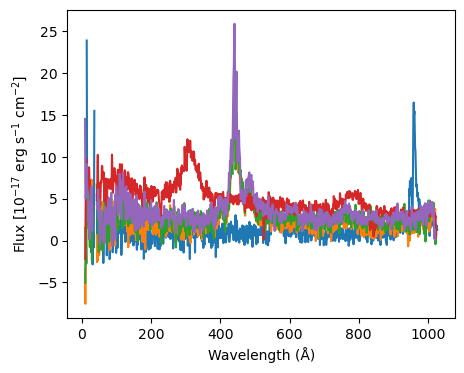

23.62069010734558


In [12]:
t0 = time.time()
plt.figure(figsize=(5,4))
for row in table[0:9]:
    res = get_spectra( row['coords'], row['shotid'], row['ifuslot'] )
    if res is not None:
        plt.plot( res[0], label=row['sdss_name'] )
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$]")
plt.show()
t1=time.time()
print(t1-t0)

It's much faster when getting data from decompressed files. To do so for your catalog please run notebook 09-BatchDecompression.ipynb after you have downloaded the datacubes locally.

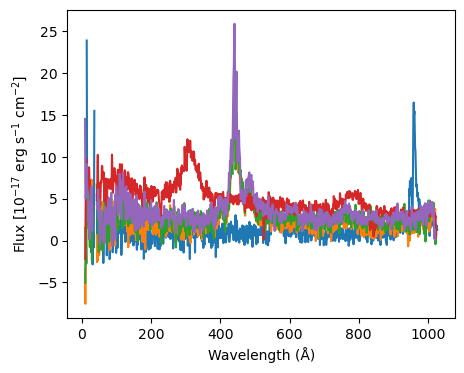

6.841578722000122


In [13]:
t0 = time.time()
plt.figure(figsize=(5,4))
for row in table[0:9]:
    res = get_spectra( row['coords'], row['shotid'], row['ifuslot'], data_dir=decompressed_dir)
    if res is not None:
        plt.plot( res[0], label=row['sdss_name'] )
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$]")
plt.show()
t1=time.time()
print(t1-t0)

## Run on full catalog using multiprocessing Pool function 

It is recommended to run in parallel if your catalog is very large.

In [16]:
from multiprocessing import Pool
from tqdm import tqdm

In [17]:
# Define a wrapper function for get_spectra to process in Pool
def process_row(row):
    return get_spectra(row['coords'], row['shotid'], row['ifuslot'], data_dir=decompressed_dir)


In [18]:
t0 = time.time()
with Pool(processes=20) as pool:
    results = pool.map( process_row, table)
t1 = time.time()
print( 'Bulk spectral extractions done in {:3.2f} min.'.format( (t1-t0)/60))

Bulk spectral extractions done in 13.38 min.


In [19]:
num_rows = len(table)
nan_array = np.full(1036, np.nan, dtype=np.float32)

# Create columns with shape (num_rows, 1036)
spectrum_col = Column(data=np.tile(nan_array, (num_rows, 1)), name='spectrum')
error_col = Column(data=np.tile(nan_array, (num_rows, 1)), name='error')
apcor_col = Column(data=np.tile(nan_array, (num_rows, 1)), name='apcor')

# Add columns to the table
table.add_column(spectrum_col)
table.add_column(error_col)
table.add_column(apcor_col)

In [20]:
for i, row in enumerate(table):
    if results[i] is not None:
        spectrum, error, apcor = results[i]
        table['spectrum'][i] = spectrum
        table['error'][i] = error
        table['apcor'][i] = apcor
    # If result is None, the initialized NaN values remain

In [21]:
# remove coords column as it doesn't jive with astropy table
table.remove_column('coords')

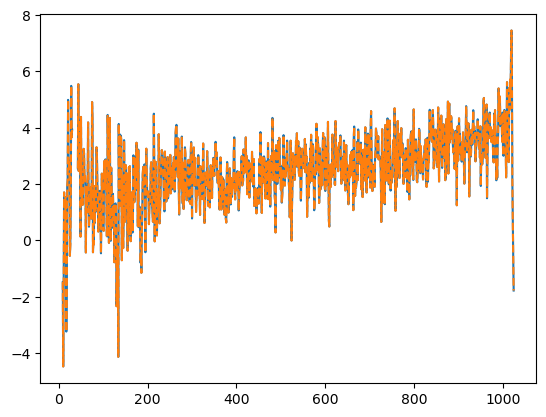

In [22]:
i=55
row = table[i]
res = get_spectra( SkyCoord(ra=row['ra']*u.deg, dec=row['dec']*u.deg), row['shotid'], row['ifuslot'], data_dir=decompressed_dir)
plt.plot( res[0], label=row['sdss_name'] )
plt.plot( table['spectrum'][i], linestyle='dashed')

In [23]:
table.write('sdss_agn_spectra_3.5arcsec.fits', overwrite=True)